# Aimes, Iowa Housing Data: Cleaning and EDA

In this notebook we look into data regarding housing sales in Aimes, Iowa and prepare it for modelling house selling price.  Quality square footage will be discussed as primary driver of price, some other features will also be explored.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import pickle

sns.set_style('darkgrid')
blue = '#20415f'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
housing = pd.read_csv('./data/train.csv', index_col=0)

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 80 columns):
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2

We first clean up column names, mainly for patsy compatibility later.  We also drop the PID column, which is just an identifying number.  Most of the nulls are simply due to not having that feature, though the reason behind lot frontage nulls is unclear at the moment.  We fill these with zeroes for now.

In [4]:
housing.columns = housing.columns.map(lambda x: x.replace(' ', ''))\
                                .map(lambda x: re.sub('^2', 'Seco', x))\
                                .map(lambda x: re.sub('^1', 'Fir', x))\
                                .map(lambda x: re.sub('^3', 'Third', x))\
                                .map(lambda x: x.replace('/', ''))

In [5]:
housing = housing.drop(['PID'], axis=1)
housing.LotFrontage = housing.LotFrontage.fillna(housing.LotFrontage.mean())
housing = housing.fillna(0)

As a first step in inspecting outliers, we make sure any years have appropriate values.  We find an unexpected value in GarageYrBlt.

In [6]:
year_column = housing.columns.map(lambda x: ('Yr' in x or 'Year' in x))
housing.loc[:,year_column].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2051.000000,2051.000000,2051.000000,2051.000000
mean,1971.708922,1984.190151,1868.725987,2007.775719
std,30.177889,21.036250,454.133654,1.312014
min,1872.000000,1950.000000,0.000000,2006.000000
25%,1953.500000,1964.500000,1957.000000,2007.000000
50%,1974.000000,1993.000000,1978.000000,2008.000000
75%,2001.000000,2004.000000,2001.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [7]:
housing.loc[housing.GarageYrBlt==2207, ['YearBuilt']]

,YearBuilt
Id,
2261,2006


It can be assumed that this garage was actually built in 2007 a year later, though if we were especially paranoid we could drop this entry entirely.  This one error is fixed now.

In [8]:
housing.loc[housing.GarageYrBlt==2207, ['GarageYrBlt']] = 2007
housing.loc[:,year_column].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2051.000000,2051.000000,2051.000000,2051.000000
mean,1971.708922,1984.190151,1868.628474,2007.775719
std,30.177889,21.036250,454.082452,1.312014
min,1872.000000,1950.000000,0.000000,2006.000000
25%,1953.500000,1964.500000,1957.000000,2007.000000
50%,1974.000000,1993.000000,1978.000000,2008.000000
75%,2001.000000,2004.000000,2001.000000,2009.000000
max,2010.000000,2010.000000,2010.000000,2010.000000


We also noticed that several categories were incorrectly classified; some area measurements are recorded as an objects, some categories are read as numerical types.  Many of the latter are left as numerical for their potentially ordinal relationship in describing sale price and are left as numeric. 

In [9]:
is_object = (housing.dtypes == 'O').values
numeric_name = housing.columns.map(lambda x: ('SF' in x) or ('Area' in x)).values
housing.loc[:,is_object & numeric_name].apply((lambda col: col.astype(int)), axis=1, inplace=True);

In [10]:
housing.MSSubClass = housing.MSSubClass.astype('category')
housing.YrSold = housing.YrSold.astype('category')

We now recast all objects as categories (though this makes no difference for analysis) and all floats as integers just to be consistent with the original data.

In [11]:
for column in housing.select_dtypes(include=object).columns:
    housing[column] = housing[column].astype('category')

In [12]:
for column in housing.select_dtypes(include=float).columns:
    housing[column] = housing[column].astype('int')

We now begin inspecting linear relationships with sale price, first what drives price up and then what drags it down.

In [13]:
housing.corr().SalePrice.sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.800207
GrLivArea       0.697038
GarageArea      0.649897
GarageCars      0.647781
TotalBsmtSF     0.629303
FirstFlrSF      0.618486
YearBuilt       0.571849
YearRemodAdd    0.550370
FullBath        0.537969
Name: SalePrice, dtype: float64

In [14]:
housing.corr().SalePrice.sort_values().head(6)

EnclosedPorch   -0.135656
KitchenAbvGr    -0.125444
OverallCond     -0.097019
BsmtHalfBath    -0.045290
LowQualFinSF    -0.041594
MiscVal         -0.007375
Name: SalePrice, dtype: float64

Many of these negative correlations we would not expect.  Overall condition somehow has a negative impact on house price, as well as having a larger enclosed porch.  These observations might be obscured by other details, though, such aggregation of unlike groups.

Examining overall quality more closely, we find that this is a good predictor of housing price, though not linear nor homoscedastic.

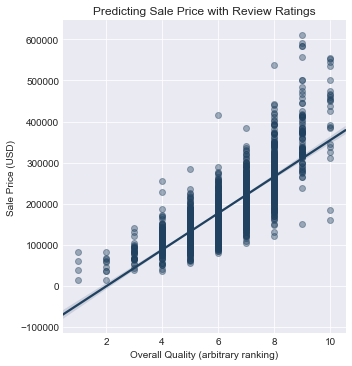

In [15]:
sns.lmplot(
    x='OverallQual', 
    y='SalePrice', 
    data=housing, 
    scatter_kws={'color':blue, 'alpha':0.4},
    line_kws={'color':blue}
);

plt.title('Predicting Sale Price with Review Ratings');
plt.xlabel('Overall Quality (arbitrary ranking)');
plt.ylabel('Sale Price (USD)');

The next highest correlation with sale price belongs to living area.  We see some of the same problems here, though at least this measure is not arbitrary and also continuous.

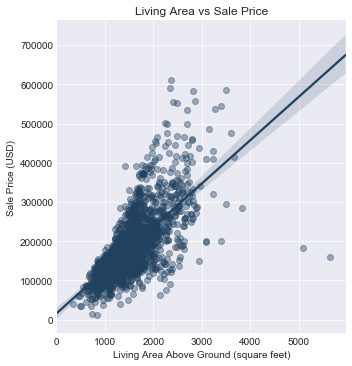

In [16]:
sns.lmplot(
    x='GrLivArea', 
    y='SalePrice', 
    data=housing,
    scatter_kws={'color':blue, 'alpha':0.4},
    line_kws={'color':blue}
);

plt.title('Living Area vs Sale Price');
plt.xlabel('Living Area Above Ground (square feet)');
plt.ylabel('Sale Price (USD)');

Intuitively, we might expect that not all square footage should be weighted equally in considering sale price.  Rather than grouping by neighborhood, which might be more accurate, we weight living square footage with their review score.  Despite the quality review score being somewhat trivial, quality square footage seems to be a good predictor of sale price on its own.  There is still the problem of skewness in distribution.

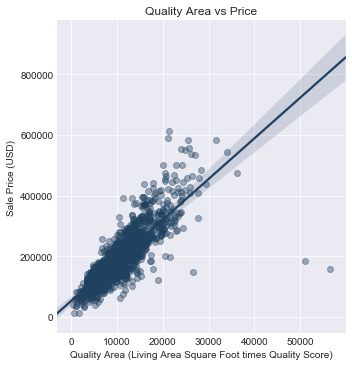

In [17]:
sns.lmplot(
    x='QualArea', 
    y='SalePrice', 
    data=housing.assign(QualArea = lambda df: df.GrLivArea*df.OverallQual),
    scatter_kws={'color':blue, 'alpha':0.4},
    line_kws={'color':blue}
);

plt.title('Quality Area vs Price');
plt.xlabel('Quality Area (Living Area Square Foot times Quality Score)');
plt.ylabel('Sale Price (USD)');

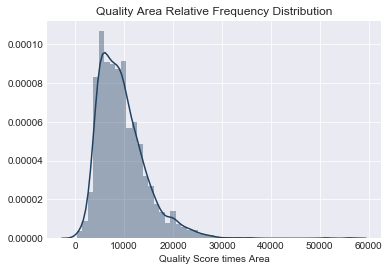

In [18]:
plt.title('Quality Area Relative Frequency Distribution')
sns.distplot(housing.assign(QualArea=lambda df: df.OverallQual*df.GrLivArea).QualArea, color=blue);
plt.xlabel('Quality Score times Area');

We address the two outliers in living area by simply tossing them out.  With just two data points, trying to fit to this would potentially be fitting to a trend that does not exist on a large scale.  We also note that houses sold in the 2000's are usually not less than $100,000.  We set an arbitrary threshold to throw out houses sold at low prices, though these do not have much an effect on the variable under examination.

In [19]:
housing = housing.query('GrLivArea <= 4500 and SalePrice > 30000')

Sale type seems to have some effect on sale price; sales of new houses and contracts have a higher median sales price than the others.  However, this might include very little new information, considering that difference in price is still mostly explained by overall quality's relationship with sale type.  There may be trends within a single grouping, though.

In [20]:
def priceByCategory(name, color = blue, query = None):
      order = housing.groupby(name).SalePrice.median().sort_values(ascending=False).index
      
      sns.swarmplot(
          x = name,
          y = 'SalePrice',
          data = housing.query(query) if query else housing,
          hue = color,
          order = order,
          palette = sns.light_palette('seagreen', n_colors = len(housing[color].unique())) if color!= blue and not query else None
      );
      
      plt.title(f'{name} versus Sale Price {"(" + query + ")" if query else ""}')
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=color if color!=blue else None)

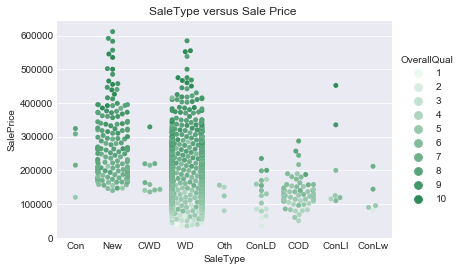

In [21]:
priceByCategory('SaleType', 'OverallQual')

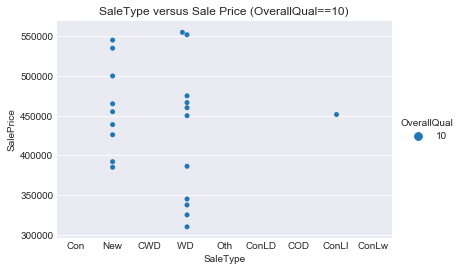

In [22]:
priceByCategory('SaleType', 'OverallQual', 'OverallQual==10')

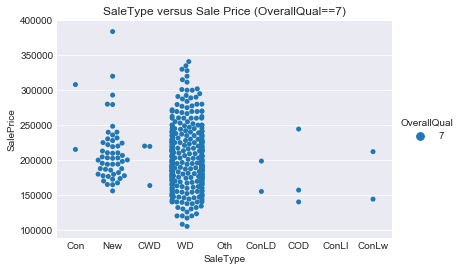

In [23]:
priceByCategory('SaleType', 'OverallQual', 'OverallQual==7')

In the same way, we can argue that external quality does give independent information.

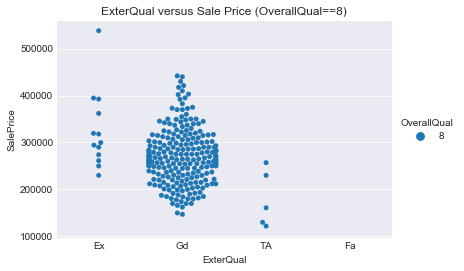

In [24]:
priceByCategory('ExterQual', 'OverallQual', 'OverallQual==8')

We now consider the possibility of relationships between explanatory variables, though this analysis is limited to detecting one-to-one relationships.

In [25]:
from itertools import combinations

In [26]:
combos = list(combinations(housing.select_dtypes(int).drop('SalePrice',axis=1).columns, 2))

In [27]:
strong_correlation = []
for combo in combos:
    corr = housing.corr().abs().loc[combo[0], combo[1]]
    if corr > 0.8:
        strong_correlation.append((combo, corr))

In [28]:
strong_correlation

[(('GrLivArea', 'TotRmsAbvGrd'), 0.8118239318730329),
 (('GarageCars', 'GarageArea'), 0.8975832344969998)]

We drop potentially redundant information, as well as the first floor area, which we intuitively expect to share information with living and other areas, as well as lot frontage.  While it is not proven that lot frontage encodes the same information as lot area, we drop it for the similar pattern when plotted against sale price.

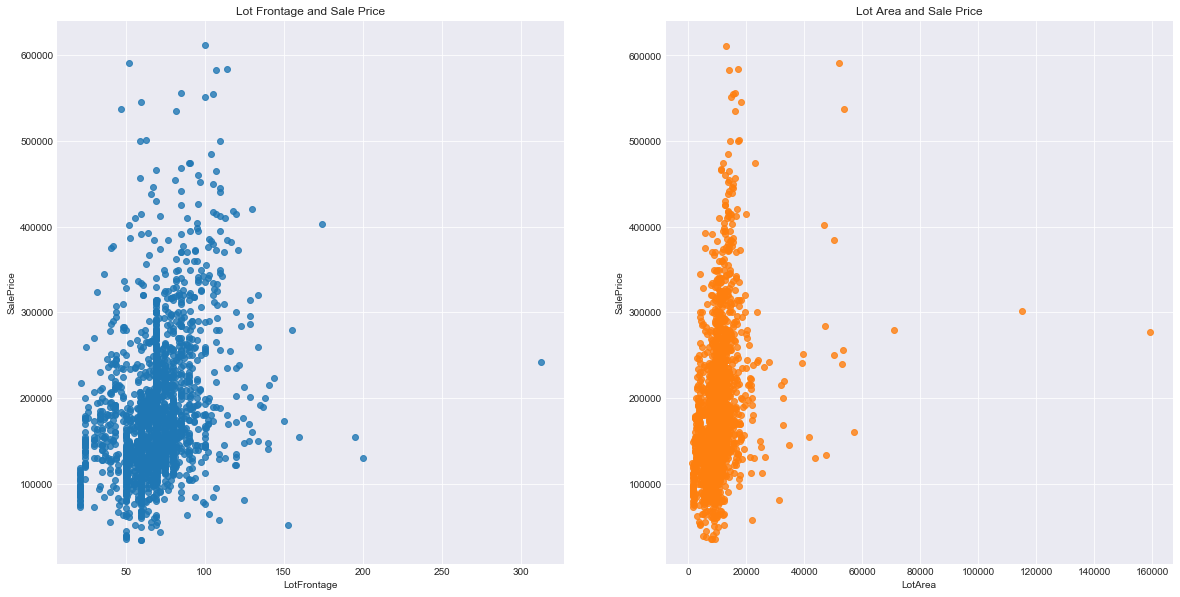

In [29]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

sns.regplot(
    ax = ax[0],
    x = 'LotFrontage',
    y = 'SalePrice',
    data = housing,
    fit_reg = False
);
ax[0].set_title('Lot Frontage and Sale Price');

sns.regplot(
    ax = ax[1],
    x = 'LotArea',
    y = 'SalePrice',
    data = housing,
    fit_reg = False
);
plt.title('Lot Area and Sale Price');

In [31]:
housing = housing.drop(['FirstFlrSF', 'TotRmsAbvGrd', 'GarageCars'], axis=1).query('LotArea < 80000 and LotFrontage < 300')

Further steps are taken before modelling sale price as a linear combination of other variables in the second notebook.

In [32]:
file = "./pickles/housingDF2.pkl"
fileObject = open(file, 'wb')

In [33]:
pickle.dump(housing, fileObject)

In [34]:
fileObject.close()